In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *
import tensorflow as tf
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Covariance evolution

In [198]:
covs = []
means = []
signals = []
xicovs = []

#define parameters
gamma = 1.0 #damping from outside 
Gamma = 0.8 #measurement rate
eta = 1 # measurement efficiency
n = 2 # number of photons?
w = 0.4 # hamornic oscillator freq mecanical
m = 1 # mass harmonic oscillator mechanical
T = 2*np.pi/w

C= np.diag([np.sqrt(4*eta*Gamma)]*2)

A = np.array([
    [0., 1/m],
    [-m*w**2, 0.]])

D = np.diag([gamma*(n + 0.5) + Gamma]*2)

## initial condition
su = n + 0.5 + Gamma/gamma
cov_in = np.diag([np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]*2)
x_in = np.array([1,0])



dt = 5e-4
tfinal = 20
tot_steps = int(tfinal/dt)

xi = lambda cov: np.dot(cov, ct(C)) #+ ct(Gamma_matrix)

covs = [cov_in]
means = [x_in]
xicovs = [xi(covs[-1])]
for k in tqdm(range(tot_steps)):
    
    x = means[-1]
    cov = covs[-1]
    XiCov = xicovs[-1]

    dy = np.dot(C, x + np.dot(np.linalg.inv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
    signals.append(dy)
    
    dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    
    covs.append(covs[-1] + dcov)
    means.append(means[-1] + dx)
    xicovs.append(xi(covs[-1]))

100%|██████████| 40000/40000 [00:01<00:00, 20665.15it/s]


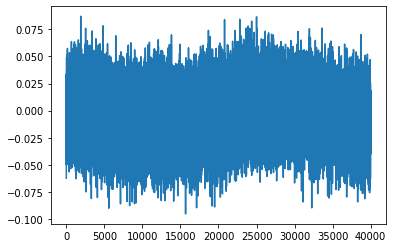

In [199]:
plt.plot([signals[k][0] for k in range(len(signals))])

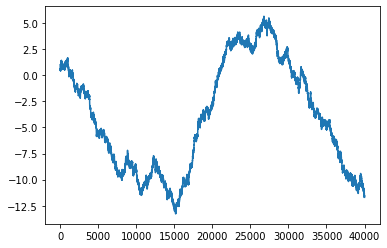

In [200]:
plt.plot([means[k][0] for k in range(len(means))])

In [191]:
tf.keras.backend.set_floatx("float64")
class ModelA(tf.keras.Model):
    def __init__(self, target_A, tfxicovsC=None, tfmeans=None, seed_val=0.1 , C=None, dt=dt, tfsignals=None):
        """
        Encoder network
        """
        super(ModelA,self).__init__()
        self.l1 = tf.keras.layers.Dense(32,kernel_initializer=tf.random_uniform_initializer(),bias_initializer = tf.keras.initializers.Zeros())
        self.l2 = tf.keras.layers.Dense(32,kernel_initializer=tf.random_uniform_initializer(),bias_initializer = tf.keras.initializers.Zeros())
        self.loutput = tf.keras.layers.Dense(4, bias_initializer = tf.keras.initializers.Zeros())
        self.total_loss = Metrica(name="total_loss")

        
        self.target_A = tf.convert_to_tensor(target_A)
        self.tfxicovsC = tfxicovsC
        self.tfmeans = tfmeans
        self.C = C
        self.dt = dt
        self.tfsignals = tfsignals
        
    def call(self, inputs):
        f = tf.nn.sigmoid(self.l1(inputs))
        f = tf.nn.sigmoid(self.l2(f))
        f = self.loutput(f)
        return f
    
    def spit_A(self):
        return tf.reshape(self(tf.ones((1,1))),(2,2))
    
    @property
    def metrics(self):
        """
        this helps monitring training
        """
        return [self.total_loss]
    
    def train_step(self, data):
        x, tfsignals = data
        
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            A_pred = self.spit_A()
            pred_signal = A_pred - self.tfxicovsC
            pred_signal = tf.matmul(self.C, pred_signal)
            pred_signal = pred_signal*self.dt
            pred_signal = tf.einsum('tij,tj->ti', pred_signal, self.tfmeans)   ## take original  (cheating)
            loss = tf.keras.losses.MeanSquaredError()(pred_signal, tfsignals)
            
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss.update_state(loss)
        return {k.name:k.result() for k in self.metrics}
    
    
class Metrica(tf.keras.metrics.Metric):
    """
    This helps to monitor training (for instance each loss)
    """
    def __init__(self, name):
        super(Metrica, self).__init__()
        self._name=name
        self.metric_variable = self.add_weight(name=name, initializer='zeros')

    def update_state(self, new_value, sample_weight=None):
        self.metric_variable.assign(new_value)

    def result(self):
        return self.metric_variable

    def reset_states(self):
        self.metric_variable.assign(0.)

In [201]:
tfxicovs = tf.convert_to_tensor(xicovs)
tfmeans = tf.cast(tf.convert_to_tensor(means), np.float64)
tfxicovsC = tf.matmul(tfxicovs, C)
tfcovs = tf.cast(tf.convert_to_tensor(covs), np.float64)
tfsignals = tf.cast(tf.convert_to_tensor(signals), np.float64)

beg = 0
end = -1
model = ModelA(target_A = A, tfxicovsC = tfxicovsC, tfmeans = tfmeans, C=C ,dt=dt, tfsignals=tfsignals)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="mse")

In [232]:
dx_pred = A - tf.einsum('tij,jl->til',tfxicovs[:-1], C)
dx_pred = tf.einsum('tij,tj->ti', dx_pred, tfmeans[:-1])
dx_pred = dx_pred + tf.einsum('tik,tk->ti', tfxicovs[:-1], tfsignals) 

In [236]:
 diffs = tfmeans[:-1]-tfmeans[1:]

In [ ]:
covs = [cov_in]
means = [x_in]
xicovs = [xi(covs[-1])]
for k in tqdm(range(tot_steps)):
    
    x = means[-1]
    cov = covs[-1]
    XiCov = xicovs[-1]

    dy = np.dot(C, x + np.dot(np.linalg.inv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
    signals.append(dy)
    
    dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    
    covs.append(covs[-1] + dcov)
    means.append(means[-1] + dx)
    xicovs.append(xi(covs[-1]))

In [276]:
dx0 = A - tf.einsum('tij,jl->til',tfxicovs[:-1], C)
dx1 = tf.einsum('tij,tj->ti', dx0, tfmeans[:-1])*dt
dx2 = dx1 + tf.einsum('tik,tk->ti', tfxicovs[:-1], tfsignals)
x = dx2 + tfmeans[:-1]    #this gives tfmeansx[1:]
lt1 = tf.einsum('ij,tj->ti',C,x)*dt
loss = lt1[:-1] - tfsignals[1:]

Text(0.5, 1.0, 'STD/dt ; 1.0')

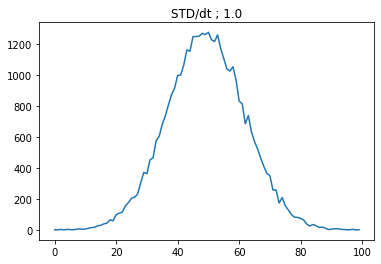

In [312]:
histo = np.histogram(loss[:,0], bins=100)
plt.plot(histo[0])
plt.title("STD/dt ; {}".format(np.round(np.std(loss[:,0])**2/dt),9))

In [202]:
A_pred = model.spit_A()
pred_signal = A_pred - model.tfxicovsC
pred_signal = tf.matmul(model.C, pred_signal)
pred_signal = pred_signal*model.dt
pred_signal = tf.einsum('tij,tj->ti', pred_signal, model.tfmeans)   ## take original  (cheating)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

